# Neural Network From Scratch – XOR & Gradient Checking

This notebook demonstrates:
- A minimal MLP solving the XOR problem.
- A simple gradient checking routine to verify backpropagation.

## 1. Setup

Import the custom library components from `lib/` and fix the random seed for reproducibility.

In [1]:
import numpy as np

from lib.layers import Dense
from lib.activations import Tanh
from lib.network import Network
from lib.losses import MSELoss
from lib.optimizer import SGD
from lib.gradcheck import gradient_check

# Reproducibility
np.random.seed(42)

## 2. XOR dataset

We define the classic XOR problem with inputs in {0, 1} and targets encoded in {-1, +1}.

In [2]:
# XOR inputs in {0, 1}
X_01 = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])

# XOR targets in {-1, +1}
y_true = np.array([
    [-1.0],
    [ 1.0],
    [ 1.0],
    [-1.0],
])

print("Original inputs (0/1):")
print(X_01)
print("\nTargets (-1/+1):")
print(y_true)

Original inputs (0/1):
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

Targets (-1/+1):
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]


## 3. Input normalization to [-1, +1]

Since we use Tanh activations (range [-1, +1]) and targets in {-1, +1},
it is natural to also map the inputs from {0, 1} to {-1, +1}:

- 0 → -1
- 1 → +1

This keeps the whole network (inputs, activations, outputs) in a consistent range.

In [3]:
# Map inputs from {0, 1} to {-1, +1}
X = 2.0 * X_01 - 1.0

print("Normalized inputs (-1/+1):")
print(X)

Normalized inputs (-1/+1):
[[-1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [ 1.  1.]]


## 4. Network architecture

We build a small MLP for XOR:

- Input: 2 units
- Hidden layer: 4 units + Tanh
- Output layer: 1 unit + Tanh

Tanh is well aligned with both the normalized inputs and the {-1, +1} targets.

In [4]:
def build_xor_network():
    """
    Simple MLP for XOR: 2 -> 4 -> 1 with Tanh activations.
    """
    net = Network()
    net.add(Dense(2, 4))
    net.add(Tanh())
    net.add(Dense(4, 1))
    net.add(Tanh())
    return net


net = build_xor_network()
loss_fn = MSELoss()
optimizer = SGD(learning_rate=0.5)

## 5. Training loop

We train the network on the (normalized) XOR data using:

- Mean Squared Error (MSE) loss
- Stochastic Gradient Descent (SGD) optimizer

In [5]:
num_epochs = 5000
loss_history = []  # store loss per epoch

for epoch in range(num_epochs):
    # Forward
    y_pred = net.forward(X)

    # Loss
    loss = loss_fn.forward(y_pred, y_true)
    loss_history.append(loss)

    # Backward
    grad_loss = loss_fn.backward(y_pred, y_true)
    net.backward(grad_loss)

    # Update
    optimizer.step(net.get_params(), net.get_grads())

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs} - loss: {loss:.6f}")

Epoch 500/5000 - loss: 0.000405
Epoch 1000/5000 - loss: 0.000188
Epoch 1500/5000 - loss: 0.000121
Epoch 2000/5000 - loss: 0.000089
Epoch 2500/5000 - loss: 0.000070
Epoch 3000/5000 - loss: 0.000057
Epoch 3500/5000 - loss: 0.000049
Epoch 4000/5000 - loss: 0.000042
Epoch 4500/5000 - loss: 0.000037
Epoch 5000/5000 - loss: 0.000033


## 6. Loss curve

We now plot the loss value over training epochs to visualize the optimization progress.

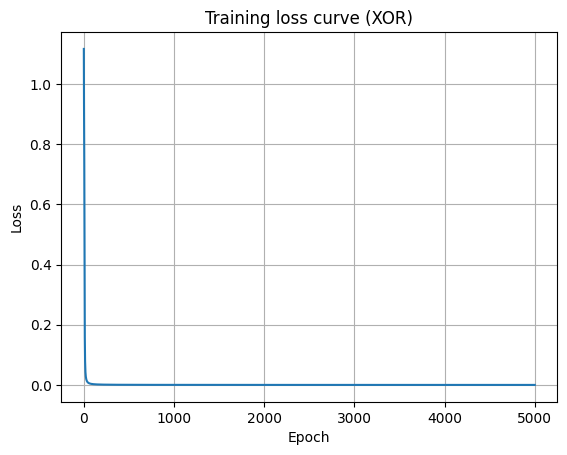

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss curve (XOR)")
plt.grid(True)
plt.show()

## 7. Evaluation on XOR

After training, we evaluate the network on the four XOR input patterns.
We inspect the raw Tanh outputs and convert them back to {-1, +1}.

In [7]:
y_pred = net.forward(X)

print("Raw outputs (Tanh):")
print(y_pred)

# Map Tanh outputs to class labels
y_decision = np.where(y_pred >= 0.0, 1.0, -1.0)

print("\nQuantized predictions (-1 / +1):")
print(y_decision)

print("\nTrue labels:")
print(y_true)

Raw outputs (Tanh):
[[-0.99433297]
 [ 0.99404573]
 [ 0.99407298]
 [-0.99442894]]

Quantized predictions (-1 / +1):
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]

True labels:
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]


## 8. Why Tanh fits naturally with {-1, +1} inputs and outputs

We normalize the XOR inputs from {0,1} → {-1,+1}, and we encode targets as {-1,+1}.
This makes **Tanh** the most natural activation function because:

1. **Range alignment**
   - Tanh outputs lie in **[-1, +1]**
   - Both inputs and targets lie in **[-1, +1]**

2. **Zero-centered activations**
   - Tanh is centered at 0
   - Inputs are also centered at 0
   - This prevents biased gradients and often speeds up training

3. **Stable gradient flow**
   - Inputs that fall in the active region of Tanh avoid saturation
   - Backpropagation becomes numerically more stable

4. **Simple decision rule**
   - output ≥ 0 → +1
   - output < 0 → -1

This alignment between input domain, activation output, and target encoding
creates a more well-conditioned learning setup.

## 9. Gradient checking

Before trusting the training process, we must verify that backpropagation
was implemented correctly.

We compare:

- Analytical gradients (computed by `.backward`)
- Numerical gradients (finite difference)

The function `gradient_check` returns the maximum difference between both.


In [8]:
net_gc = build_xor_network()
loss_fn_gc = MSELoss()

max_diff = gradient_check(
    network=net_gc,
    loss_fn=loss_fn_gc,
    X=X,
    y_true=y_true,
    eps=1e-5,
)

print("Max absolute difference:", max_diff)

if max_diff < 1e-4:
    print("Gradient check PASSED")
else:
    print("Gradient check FAILED")

Max absolute difference: 1.9621443358985857e-11
Gradient check PASSED


### Gradient checking summary

To ensure that the backpropagation implementation is correct,
we performed numerical gradient checking on the XOR network.

The maximum absolute difference between analytical and numerical
gradients was on the order of 1e-11, which confirms that the
gradients are implemented correctly.

# (1) Neural Network From Scratch – XOR

This notebook demonstrates:
- A minimal MLP solving the XOR problem.
- A simple gradient checking routine to verify backpropagation.

## 1. Setup

Import the custom library components from `lib/` and fix the random seed for reproducibility.

In [9]:
import numpy as np

from lib.layers import Dense
from lib.activations import Tanh
from lib.network import Network
from lib.losses import MSELoss
from lib.optimizer import SGD
from lib.gradcheck import gradient_check

# Reproducibility
np.random.seed(42)

## 2. XOR dataset

We define the classic XOR problem with inputs in {0, 1} and targets encoded in {-1, +1}.

In [10]:
# XOR inputs in {0, 1}
X_01 = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])

# XOR targets in {-1, +1}
y_true = np.array([
    [-1.0],
    [ 1.0],
    [ 1.0],
    [-1.0],
])

print("Original inputs (0/1):")
print(X_01)
print("\nTargets (-1/+1):")
print(y_true)

Original inputs (0/1):
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

Targets (-1/+1):
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]


## 3. Input normalization to [-1, +1]

Since we use Tanh activations (range [-1, +1]) and targets in {-1, +1},
it is natural to also map the inputs from {0, 1} to {-1, +1}:

- 0 → -1
- 1 → +1

This keeps the whole network (inputs, activations, outputs) in a consistent range.

In [11]:
# Map inputs from {0, 1} to {-1, +1}
X = 2.0 * X_01 - 1.0

print("Normalized inputs (-1/+1):")
print(X)

Normalized inputs (-1/+1):
[[-1. -1.]
 [-1.  1.]
 [ 1. -1.]
 [ 1.  1.]]


## 4. Network architecture

We build a small MLP for XOR:

- Input: 2 units
- Hidden layer: 4 units + Tanh
- Output layer: 1 unit + Tanh

Tanh is well aligned with both the normalized inputs and the {-1, +1} targets.

In [12]:
def build_xor_network():
    """
    Simple MLP for XOR: 2 -> 4 -> 1 with Tanh activations.
    """
    net = Network()
    net.add(Dense(2, 4))
    net.add(Tanh())
    net.add(Dense(4, 1))
    net.add(Tanh())
    return net


net = build_xor_network()
loss_fn = MSELoss()
optimizer = SGD(learning_rate=0.5)

## 5. Training loop

We train the network on the (normalized) XOR data using:

- Mean Squared Error (MSE) loss
- Stochastic Gradient Descent (SGD) optimizer

In [13]:
num_epochs = 5000
loss_history = []  # store loss per epoch

for epoch in range(num_epochs):
    # Forward
    y_pred = net.forward(X)

    # Loss
    loss = loss_fn.forward(y_pred, y_true)
    loss_history.append(loss)

    # Backward
    grad_loss = loss_fn.backward(y_pred, y_true)
    net.backward(grad_loss)

    # Update
    optimizer.step(net.get_params(), net.get_grads())

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs} - loss: {loss:.6f}")

Epoch 500/5000 - loss: 0.000405
Epoch 1000/5000 - loss: 0.000188
Epoch 1500/5000 - loss: 0.000121
Epoch 2000/5000 - loss: 0.000089
Epoch 2500/5000 - loss: 0.000070
Epoch 3000/5000 - loss: 0.000057
Epoch 3500/5000 - loss: 0.000049
Epoch 4000/5000 - loss: 0.000042
Epoch 4500/5000 - loss: 0.000037
Epoch 5000/5000 - loss: 0.000033


## 6. Loss curve

We now plot the loss value over training epochs to visualize the optimization progress.

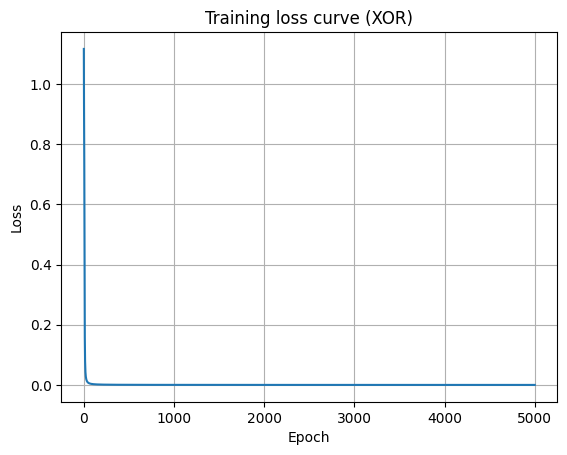

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss curve (XOR)")
plt.grid(True)
plt.show()

## 7. Evaluation on XOR

After training, we evaluate the network on the four XOR input patterns.
We inspect the raw Tanh outputs and convert them back to {-1, +1}.

In [15]:
y_pred = net.forward(X)

print("Raw outputs (Tanh):")
print(y_pred)

# Map Tanh outputs to class labels
y_decision = np.where(y_pred >= 0.0, 1.0, -1.0)

print("\nQuantized predictions (-1 / +1):")
print(y_decision)

print("\nTrue labels:")
print(y_true)

Raw outputs (Tanh):
[[-0.99433297]
 [ 0.99404573]
 [ 0.99407298]
 [-0.99442894]]

Quantized predictions (-1 / +1):
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]

True labels:
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]]


## 8. Why Tanh fits naturally with {-1, +1} inputs and outputs

We normalize the XOR inputs from {0,1} → {-1,+1}, and we encode targets as {-1,+1}.
This makes **Tanh** the most natural activation function because:

1. **Range alignment**
   - Tanh outputs lie in **[-1, +1]**
   - Both inputs and targets lie in **[-1, +1]**

2. **Zero-centered activations**
   - Tanh is centered at 0
   - Inputs are also centered at 0
   - This prevents biased gradients and often speeds up training

3. **Stable gradient flow**
   - Inputs that fall in the active region of Tanh avoid saturation
   - Backpropagation becomes numerically more stable

4. **Simple decision rule**
   - output ≥ 0 → +1
   - output < 0 → -1

This alignment between input domain, activation output, and target encoding
creates a more well-conditioned learning setup.

# (2) Gradient checking

Before trusting the training process, we must verify that backpropagation
was implemented correctly.

We compare:

- Analytical gradients (computed by `.backward`)
- Numerical gradients (finite difference)

The function `gradient_check` returns the maximum difference between both.


In [16]:
net_gc = build_xor_network()
loss_fn_gc = MSELoss()

max_diff = gradient_check(
    network=net_gc,
    loss_fn=loss_fn_gc,
    X=X,
    y_true=y_true,
    eps=1e-5,
)

print("Max absolute difference:", max_diff)

if max_diff < 1e-4:
    print("Gradient check PASSED")
else:
    print("Gradient check FAILED")

Max absolute difference: 1.9621443358985857e-11
Gradient check PASSED


## Section 3: Autoencoder on MNIST (Reconstruction)
We train an autoencoder using our from-scratch MLP library (NumPy). The model learns to reconstruct MNIST images using MSE loss and SGD.

-Dataset is standard MNIST

-Loaded via OpenML using scikit-learn

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from lib.layers import Dense
from lib.activations import Tanh, Sigmoid  # استخدمنا Tanh لأنك قلت تفضله، وSigmoid في آخر decoder لأن البيانات 0..1
from lib.network import Network
from lib.losses import MSELoss
from lib.optimizer import SGD


In [18]:
# Load MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Data and labels
X = mnist.data.astype(np.float32)    # (70000, 784)
y = mnist.target.astype(int)         # labels (used later in Section 4)

# Normalize pixel values from [0, 255] -> [-1, 1] to match Tanh output range
X = (X / 255.0) * 2.0 - 1.0

# Train/Test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)
print("X range:", (X_train.min(), X_train.max()))



X_train: (60000, 784) X_test: (10000, 784)
y_train: (60000,) y_test: (10000,)
X range: (np.float32(-1.0), np.float32(1.0))


## Build the Autoencoder

In [19]:
# ===============================
# Autoencoder Architecture
# 784 → 256 → 128 → 256 → 784
# All layers use Tanh activation
# Inputs and targets are in [-1, 1]
# ===============================

latent_dim = 128

autoencoder = Network()

# ----- Encoder -----
autoencoder.add(Dense(784, 256))
autoencoder.add(Tanh())

autoencoder.add(Dense(256, latent_dim))
autoencoder.add(Tanh())

# ----- Decoder -----
autoencoder.add(Dense(latent_dim, 256))
autoencoder.add(Tanh())
autoencoder.add(Dense(256, 784))
autoencoder.add(Tanh())   # Output in [-1, 1]

## Loss + Optimizer

In [20]:
loss_fn = MSELoss()
optimizer = SGD(learning_rate=0.1)


## Training Loop

In [21]:
def train_autoencoder(net, X, epochs=5, batch_size=128):
    """
    Trains an autoencoder with MSE loss where the target equals the input.
    Returns a list of epoch losses.
    """
    n = X.shape[0]
    losses = []

    for epoch in range(epochs):
        idx = np.random.permutation(n)
        Xs = X[idx]

        epoch_loss = 0.0
        num_batches = 0

        for i in range(0, n, batch_size):
            batch = Xs[i:i + batch_size]

            # Forward pass
            recon = net.forward(batch)

            # Reconstruction loss (input = target)
            loss = loss_fn.forward(recon, batch)

            # Backward pass
            grad = loss_fn.backward(recon, batch)
            net.backward(grad)

            # Update
            optimizer.step(net.get_params(), net.get_grads())

            epoch_loss += loss
            num_batches += 1

        epoch_loss /= num_batches
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} - MSE loss: {epoch_loss:.6f}")

    return losses


In [22]:
# Start with a smaller subset for a quick sanity check
X_train_small = X_train

# Train longer to reduce the loss and get clearer reconstructions
loss_curve = train_autoencoder(
    autoencoder,
    X_train_small,
    epochs=40,
    batch_size=128
)



Epoch 1/40 - MSE loss: 0.344010
Epoch 2/40 - MSE loss: 0.270392
Epoch 3/40 - MSE loss: 0.268293
Epoch 4/40 - MSE loss: 0.262232
Epoch 5/40 - MSE loss: 0.247200
Epoch 6/40 - MSE loss: 0.228853
Epoch 7/40 - MSE loss: 0.209152
Epoch 8/40 - MSE loss: 0.193200
Epoch 9/40 - MSE loss: 0.181337
Epoch 10/40 - MSE loss: 0.172325
Epoch 11/40 - MSE loss: 0.164562
Epoch 12/40 - MSE loss: 0.157589
Epoch 13/40 - MSE loss: 0.151059
Epoch 14/40 - MSE loss: 0.144956
Epoch 15/40 - MSE loss: 0.139584
Epoch 16/40 - MSE loss: 0.134862
Epoch 17/40 - MSE loss: 0.130604
Epoch 18/40 - MSE loss: 0.126741
Epoch 19/40 - MSE loss: 0.123256
Epoch 20/40 - MSE loss: 0.120120
Epoch 21/40 - MSE loss: 0.117246
Epoch 22/40 - MSE loss: 0.114556
Epoch 23/40 - MSE loss: 0.111973
Epoch 24/40 - MSE loss: 0.109454
Epoch 25/40 - MSE loss: 0.106995
Epoch 26/40 - MSE loss: 0.104634
Epoch 27/40 - MSE loss: 0.102388
Epoch 28/40 - MSE loss: 0.100266
Epoch 29/40 - MSE loss: 0.098280
Epoch 30/40 - MSE loss: 0.096438
Epoch 31/40 - MSE l

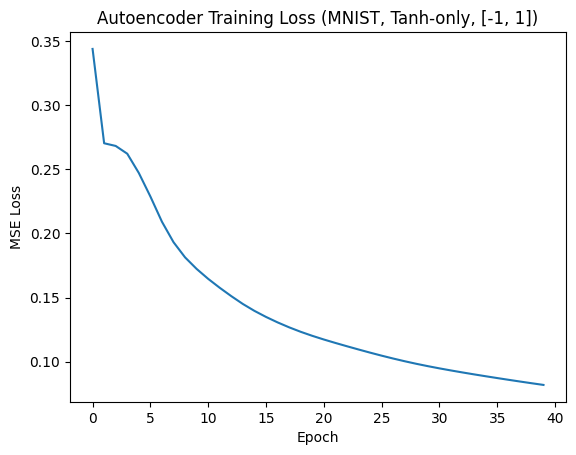

In [23]:
plt.figure()
plt.plot(loss_curve)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss (MNIST, Tanh-only, [-1, 1])")
plt.show()


In [24]:
def show_reconstructions(net, X, n=10):
    """
    Displays n original images (top) and their reconstructions (bottom).
    Data is in [-1, 1], so it is mapped to [0, 1] for visualization only.
    """
    sample = X[:n]
    recon = net.forward(sample)

    # Map from [-1, 1] to [0, 1] for display
    sample_vis = (sample + 1.0) / 2.0
    recon_vis  = (recon  + 1.0) / 2.0

    plt.figure(figsize=(12, 3))
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(sample_vis[i].reshape(28, 28), cmap="gray")
        plt.axis("off")

        # Reconstructed images
        plt.subplot(2, n, n + i + 1)
        plt.imshow(recon_vis[i].reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()


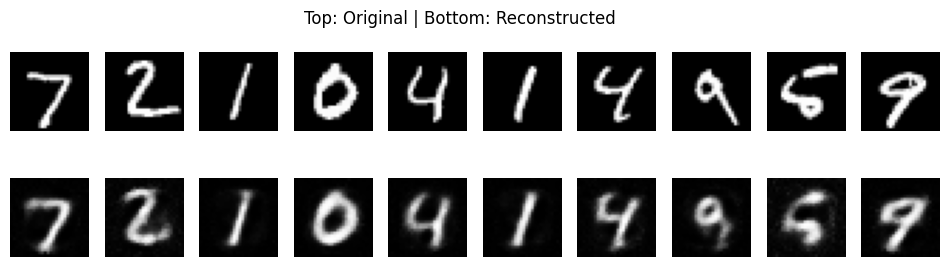

In [25]:
show_reconstructions(autoencoder, X_test, n=10)


The reconstructed images are slightly blurry due to the use of a simple fully connected architecture and SGD optimizer, but they clearly preserve the structure of the original digits.

# Section 4: Using the Autoencoder as a Feature Extractor

we use the trained autoencoder to extract compact feature representations (latent vectors) from MNIST images.
Instead of training a classifier on the raw 784-dimensional pixels, we train it on the compressed latent space, which is more informative and lower-dimensional.

## 4.1 Extract Latent Features from the Encoder

We discard the decoder and use only the encoder output (128 features) as input to a classifier.

In [26]:
def encode_from_autoencoder(autoencoder, X):
    """
    Extract latent features using the ENCODER part only.
    Encoder structure:
    Dense(784→256) → Tanh → Dense(256→128) → Tanh
    """
    z = X
    for layer in autoencoder.layers[:4]:
        z = layer.forward(z)
    return z

# Generate latent representations
Z_train = encode_from_autoencoder(autoencoder, X_train)
Z_test  = encode_from_autoencoder(autoencoder, X_test)

print("Z_train shape:", Z_train.shape)  # (60000, 128)
print("Z_test shape :", Z_test.shape)   # (10000, 128)
print("Z value range:", Z_train.min(), Z_train.max())

Z_train shape: (60000, 128)
Z_test shape : (10000, 128)
Z value range: -0.9994639663064389 0.9988302949520527


## 4.2 Prepare Labels [-1, +1]

In [27]:
def one_hot_pm1(y, num_classes=10):
    """
    One-hot encoding in {-1, +1} to match Tanh output
    """
    y = y.astype(int)
    Y = -np.ones((len(y), num_classes), dtype=np.float32)
    Y[np.arange(len(y)), y] = 1.0
    return Y

Y_train = one_hot_pm1(y_train, 10)
Y_test  = one_hot_pm1(y_test, 10)

print("Y_train shape:", Y_train.shape)  # (60000, 10)

Y_train shape: (60000, 10)


## 4.3 Build the Classifier Network

In [28]:
classifier = Network() #>> bs kda b2t fully connected
classifier.add(Dense(128, 64))
classifier.add(Tanh())
classifier.add(Dense(64, 10))
classifier.add(Tanh())

loss_fn_cls = MSELoss()
optimizer_cls = SGD(learning_rate=0.1)

## 4.4 Train the Classifier on Latent Features


In [29]:
def train_classifier(net, X, Y, loss_fn, optimizer,
                     epochs=20, batch_size=256, shuffle=True):

    n = X.shape[0]
    loss_history = []

    for epoch in range(epochs):
        if shuffle:
            idx = np.random.permutation(n)
            X_epoch = X[idx]
            Y_epoch = Y[idx]
        else:
            X_epoch = X
            Y_epoch = Y

        epoch_loss = 0.0
        steps = 0

        for i in range(0, n, batch_size):
            xb = X_epoch[i:i+batch_size]
            yb = Y_epoch[i:i+batch_size]

            # Forward
            y_pred = net.forward(xb)

            # Loss
            loss = loss_fn.forward(y_pred, yb)
            epoch_loss += loss
            steps += 1

            # Backward
            grad = loss_fn.backward(y_pred, yb)
            net.backward(grad)

            # Update
            optimizer.step(net.get_params(), net.get_grads())

        epoch_loss /= steps
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} - MSE loss: {epoch_loss:.6f}")

    return loss_history


loss_cls = train_classifier(
    classifier,
    Z_train,
    Y_train,
    loss_fn_cls,
    optimizer_cls,
    epochs=20,
    batch_size=256
)


Epoch 1/20 - MSE loss: 0.247975
Epoch 2/20 - MSE loss: 0.137252
Epoch 3/20 - MSE loss: 0.116845
Epoch 4/20 - MSE loss: 0.106829
Epoch 5/20 - MSE loss: 0.100413
Epoch 6/20 - MSE loss: 0.095539
Epoch 7/20 - MSE loss: 0.091582
Epoch 8/20 - MSE loss: 0.088217
Epoch 9/20 - MSE loss: 0.085258
Epoch 10/20 - MSE loss: 0.082530
Epoch 11/20 - MSE loss: 0.080014
Epoch 12/20 - MSE loss: 0.077664
Epoch 13/20 - MSE loss: 0.075488
Epoch 14/20 - MSE loss: 0.073470
Epoch 15/20 - MSE loss: 0.071514
Epoch 16/20 - MSE loss: 0.069807
Epoch 17/20 - MSE loss: 0.068175
Epoch 18/20 - MSE loss: 0.066606
Epoch 19/20 - MSE loss: 0.065058
Epoch 20/20 - MSE loss: 0.063667


## 4.5 Evaluate Classification Accuracy

In [31]:
def accuracy_from_tanh_outputs(outputs, y_true):
    """
    Compute Top-1 accuracy from Tanh outputs
    """
    y_pred = np.argmax(outputs, axis=1)
    return np.mean(y_pred == y_true)

out_test = classifier.forward(Z_test)
acc = accuracy_from_tanh_outputs(out_test, y_test)

print("Test Accuracy:", acc)


Test Accuracy: 0.9179


“The autoencoder successfully learned a compact latent representation of MNIST images.
Using these learned features, a simple fully-connected classifier achieved 91.8% test accuracy, demonstrating the effectiveness of representation learning even with a purely from-scratch implementation.”

### 6. Test Autoencoder on External Image


File exists: True
Path: D:\college\Semester9\CI_project\test.jpg


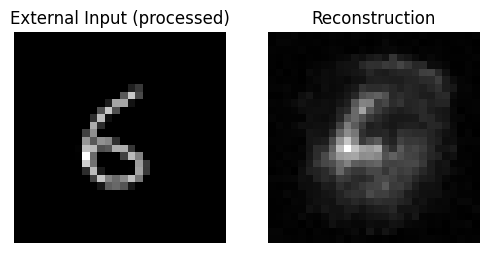

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_external_image_as_mnist(path):
    """
    Convert an external image into MNIST-like input:
    - grayscale
    - resize to 28x28
    - invert if needed (MNIST: bright digit on dark background)
    - normalize to [-1, +1] because the autoencoder uses Tanh
    - flatten to (1, 784)
    """
    img = Image.open(path).convert("L")     # grayscale
    img = img.resize((28, 28))             # MNIST size

    arr = np.array(img).astype(np.float32)

    # If background is white (high mean), invert to match MNIST style
    if arr.mean() > 127:
        arr = 255.0 - arr

    # Normalize: 0..255 -> 0..1 -> [-1, +1]
    arr = arr / 255.0
    arr = arr * 2.0 - 1.0

    x = arr.reshape(1, 784)
    return x

def show_external_reconstruction(autoencoder, img_path):
    # 1) Check that the file exists
    print("File exists:", os.path.exists(img_path))
    print("Path:", img_path)

    # 2) Load and preprocess
    x = load_external_image_as_mnist(img_path)

    # 3) Reconstruct
    recon = autoencoder.forward(x)

    # 4) Visualize (map [-1,+1] -> [0,1] for display only)
    x_vis = (x.reshape(28, 28) + 1.0) / 2.0
    r_vis = (recon.reshape(28, 28) + 1.0) / 2.0

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("External Input (processed)")
    plt.imshow(x_vis, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstruction")
    plt.imshow(r_vis, cmap="gray")
    plt.axis("off")
    plt.show()

# ======= CHANGE THIS PATH =======
img_path = r"D:\college\Semester9\CI_project\test.jpg"   # <-- put your real path here
show_external_reconstruction(autoencoder, img_path)


Because the autoencoder was trained using MSE loss and a compressed latent space. The goal is reconstruction of the overall structure, not pixel-perfect recovery.